In [1]:
# Import packages
import xarray as xr
import numpy as np
import subprocess
import pandas as pd
import glob
import os
import sys
from datetime import datetime as dt


# Import packages for plotting
from matplotlib.collections import PolyCollection 
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt 
import cartopy.feature as cfeature
import cartopy.crs as ccrs

In [2]:
xr.open_dataset('/scratch/snx3000/amols/data/camchem_data/camchem_2019021206_icon.nc')

<xarray.Dataset> Size: 2GB
Dimensions:    (time: 1, lev: 56, ncells: 90268, vertices: 3, ilev: 57, bnds: 2)
Coordinates:
    clat       (ncells) float64 722kB ...
    clon       (ncells) float64 722kB ...
  * ilev       (ilev) float64 456B 1.651 2.085 2.62 3.276 ... 970.0 985.0 1e+03
  * lev        (lev) float64 448B 1.868 2.353 2.948 3.677 ... 962.5 977.5 992.5
  * time       (time) datetime64[ns] 8B 2019-02-12T06:00:00
Dimensions without coordinates: ncells, vertices, bnds
Data variables: (12/107)
    ALKNIT     (time, lev, ncells) float32 20MB ...
    BCARY      (time, lev, ncells) float32 20MB ...
    BENZENE    (time, lev, ncells) float32 20MB ...
    BIGALD     (time, lev, ncells) float32 20MB ...
    BIGALD1    (time, lev, ncells) float32 20MB ...
    BIGALD2    (time, lev, ncells) float32 20MB ...
    ...         ...
    soa3_a1    (time, lev, ncells) float32 20MB ...
    soa3_a2    (time, lev, ncells) float32 20MB ...
    soa4_a1    (time, lev, ncells) float32 20MB ...
    soa4_a2    (time, lev, ncells) float32 20MB ...
    soa5_a1    (time, lev, ncells) float32 20MB ...
    soa5_a2    (time, lev, ncells) float32 20MB ...
Attributes: (12/17)
    CDI:                        Climate Data Interface version 1.9.10 (https:...
    Conventions:                CF-1.0
    number_of_grid_used:        99
    uuidOfHGrid:                b9e34212-147d-b711-d883-512d24492a00
    source:                     CAM
    case:                       fmerra.2.1003.FCSD.f09.qfedcmip.56L.001.branch02
    ...                         ...
    time_period_freq:           hour_6
    nco_openmp_thread_number:   1
    CDO:                        Climate Data Operators version 1.9.10 (https:...
    history:                    Thu May 16 11:23:16 2024: ncks chem_final.nc ...
    NCO:                        netCDF Operators version 5.0.4 (Homepage = ht...
    history_of_appended_files:  Thu May 16 11:23:15 2024: Appended file vert_...

In [3]:
def plot_ICON_map(data, var, minlim, maxlim, title, unit, scale=Normalize, colormap='viridis',
             west_lon=-13, east_lon=28, south_lat=32, north_lat = 68, save=False, save_as=None, output_path=None,
             date=None, text=False, left_label=True):
    '''
    Plot a map on the ICON grid

    Parameters
    ----------
    data : ds
        Contains the dataset of which a variable is plotted (needed to extract the grid)

    var : 2D array
        Contains the values to be plotted (with both scanline and gr_pixel dimension)

    minlim, maxlim : int
        Defines the range of values to be plotted

    title : str
        Defines the title of the plot

    Unit : str
        Defines the unit of the colorbar

    Scale : str
        LogNorm() will put the data on a logarithmic scale

    colormap : str
        Defines the colormap to be plotted   

    west_lon, east_lon, south_lat, north_lat : int
        Define the plot domain   
        
    Returns
    -------

    Shows the plot of the variable

    '''
    fig = plt.figure(figsize=(5,8))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

    ### Plot results
    ICON_grid = data

    lonc = ICON_grid.clon_bnds.values
    latc = ICON_grid.clat_bnds.values

    n_cells = ICON_grid.clat.values.size
    corners = np.zeros((n_cells, 3, 2)) 
    corners[:, :, 0] = lonc
    corners[:, :, 1] = latc
    corners = np.rad2deg(corners)

    poly_coll = PolyCollection( 
            corners, 
            cmap=colormap, 
            norm=scale(vmin=minlim, vmax=maxlim), 
            edgecolors="red", 
            linewidth=0.0, 
            antialiased=False,  # AA will help show the line when set to true 
            alpha=1, 
    ) 

    # Add the collection to the ax 
    ax.add_collection(poly_coll) 

    # Add counties
    ax.add_feature(cfeature.NaturalEarthFeature(
            category='cultural',
            name='admin_0_countries',
            scale='10m',
            facecolor='none',
            edgecolor='black',
            linewidth=0.5))

    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, color='grey', linestyle='--')
    gl.top_labels = False  
    gl.right_labels = False
    if left_label == False:
        gl.left_labels = False  
    gl.xlabel_style = {'size': 12, 'color': 'black'}
    gl.ylabel_style = {'size': 12, 'color': 'black'}

    # Set the field you want to see
    poly_coll.set_array(var)  
    # cbar = plt.colorbar(poly_coll,fraction=0.046, pad=0.04, extend='both')
    # cbar.set_label(unit, rotation =270)
    ax.set_title(title)
    ax.set_xlim([west_lon, east_lon])
    ax.set_ylim([south_lat, north_lat])

    # Add colorbar below the plot
    cbar = plt.colorbar(poly_coll, fraction=0.046, pad=0.04, extend='both', orientation='horizontal')
    cbar.set_label(unit, rotation=0)


    # Calculate and add average domain value text if text is True
    if text:
        avg_domain_value = np.nanmean(var.values)  # Calculate the average domain value
        if 0.01 <= abs(avg_domain_value) < 1000:  # Check the magnitude of the value
            avg_text = f'avg: {avg_domain_value:.1f} {unit}'  # Display as float with 2 decimal places
        else:
            avg_text = f'avg: {avg_domain_value:.1e} {unit}'  # Display in scientific notation
        ax.text(0.02, 0.02, avg_text, transform=ax.transAxes, fontsize=10, verticalalignment='bottom',
                horizontalalignment='left', bbox=dict(facecolor='white', alpha=0.8))  # Add text annotation
        

    if save == True:
        if date is not None:
            plt.savefig(f'{output_path}/{save_as}_{date}.png', dpi=300, bbox_inches='tight')


### Plot interpolated data

In [4]:
# def process_files_and_aggregate(ICON_filepath, camchem_filepath, month, hour, species):
#     changes = []
#     biases = []
#     ratios = []
#     avgs_icon = []
#     avgs_camchem = []
    
#     days = list(range(15, 25))  # Days 13-26

#     for day in days:
#         icon_ds = xr.open_dataset(f'{ICON_filepath}/interp_icon_2019{month}{day}T{hour}.nc')
#         camchem_ds= xr.open_dataset(f'{camchem_filepath}/interp_camchem_2019{month}{day}T{hour}.nc')

#         # camchem_ds = camchem_ds.squeeze('time').drop_vars('time')

#         no2_icon = icon_ds[species]
#         no2_camchem = camchem_ds[species]  
#         change = 2*(no2_icon - no2_camchem) / (no2_icon+no2_camchem) * 100
#         bias = (no2_icon - no2_camchem)
#         ratio = (no2_icon / no2_camchem)

#         changes.append(change)
#         biases.append(bias)
#         ratios.append(ratio)
#         avgs_icon.append(no2_icon)
#         avgs_camchem.append(no2_camchem)
    
#     # Concatenate and calculate means
#     combined_changes = xr.concat(changes, dim='file')
#     combined_biases = xr.concat(biases, dim='file')
#     combined_ratios = xr.concat(ratios, dim='file')
#     combined_avgs_icon = xr.concat(avgs_icon, dim='file')
#     combined_avgs_camchem = xr.concat(avgs_camchem, dim='file')
    
#     mean_change = combined_changes.mean(dim='file')
#     mean_bias = combined_biases.mean(dim='file')
#     mean_ratio = combined_ratios.mean(dim='file')
#     mean_icon = combined_avgs_icon.mean(dim='file')
#     mean_camchem = combined_avgs_camchem.mean(dim='file')
    
#     return mean_change, mean_bias, mean_ratio, mean_icon, mean_camchem

def process_files_and_aggregate(ICON_filepath, camchem_filepath, start_day, end_day, hour, species):
    changes = []
    biases = []
    ratios = []
    avgs_icon = []
    avgs_camchem = []
    
    days = np.arange(start_day, end_day + 1)  # Generate a list of days from start_day to end_day

    for day in days:
        day_str = np.datetime_as_string(day, unit='D').replace('-', '')
        icon_file = f'{ICON_filepath}/interp_icon_{day_str}T{hour}.nc'
        camchem_file = f'{camchem_filepath}/interp_camchem_{day_str}T{hour}.nc'

        if not os.path.exists(icon_file) or not os.path.exists(camchem_file):
            print(f"Skipping {day_str} due to missing file.")
            continue

        icon_ds = xr.open_dataset(icon_file)
        camchem_ds = xr.open_dataset(camchem_file)

        no2_icon = icon_ds[species]
        no2_camchem = camchem_ds[species]  
        change = 2 * (no2_icon - no2_camchem) / (no2_icon + no2_camchem) * 100
        bias = no2_icon - no2_camchem
        ratio = no2_icon / no2_camchem

        changes.append(change)
        biases.append(bias)
        ratios.append(ratio)
        avgs_icon.append(no2_icon)
        avgs_camchem.append(no2_camchem)
    
    # Concatenate and calculate means
    combined_changes = xr.concat(changes, dim='file')
    combined_biases = xr.concat(biases, dim='file')
    combined_ratios = xr.concat(ratios, dim='file')
    combined_avgs_icon = xr.concat(avgs_icon, dim='file')
    combined_avgs_camchem = xr.concat(avgs_camchem, dim='file')
    
    mean_change = combined_changes.mean(dim='file')
    mean_bias = combined_biases.mean(dim='file')
    mean_ratio = combined_ratios.mean(dim='file')
    mean_icon = combined_avgs_icon.mean(dim='file')
    mean_camchem = combined_avgs_camchem.mean(dim='file')
    
    return mean_change, mean_bias, mean_ratio, mean_icon, mean_camchem

In [5]:
# ICON_filepath = '/scratch/snx3000/amols/data/nudged_ICON_data/pres_interp'
# camchem_filepath = '/scratch/snx3000/amols/data/camchem_data/pres_interp'
# species_list = ['NO2', 'NO', 'HNO3', 'N2O5', 'PAN', 'NOx', 'NOy', 'NOz', 'NOx_NOy', 'NOx_NO2', 'O3', 'OH', 'CH3CHO']

# for month in ['02','07']:
#     for hour in ['12', '00']:
#         for species in species_list:
#             # Process files and aggregate results
#             result = process_files_and_aggregate(ICON_filepath, camchem_filepath, month, hour, species)
            
#             # Unpack and rename variables
#             # Unpack the result and assign to separate variables with dynamically constructed names
#             exec(f'mean_change_{species}_2019{month}T{hour}, mean_bias_{species}_2019{month}T{hour}, \
#                   mean_ratio_{species}_2019{month}T{hour}, mean_icon_{species}_2019{month}T{hour}, \
#                   mean_camchem_{species}_2019{month}T{hour} = result')
            
#             # Print confirmation
#             print(f"Processed {species} for 2019-{month}T{hour}:00")


ICON_filepath = '/scratch/snx3000/amols/data/nudged_ICON_data/pres_interp'
camchem_filepath = '/scratch/snx3000/amols/data/camchem_data/pres_interp'
# species_list = ['NO2', 'NO', 'HNO3', 'N2O5', 'PAN', 'NOx', 'NOy', 'NOz', 'NOx_NOy', 'NOx_NO2', 'O3', 'OH', 'CH3CHO', 'CO', 'temp']
species_list = ['temp']


# Define date ranges
start_feb = np.datetime64('2019-02-12')
end_mar = np.datetime64('2019-03-11')
start_jul = np.datetime64('2019-07-12')
end_aug = np.datetime64('2019-08-11')

for hour in ['12', '00']:
    for species in species_list:
        # Process files and aggregate results for February-March
        result_feb = process_files_and_aggregate(ICON_filepath, camchem_filepath, start_feb, end_mar, hour, species)
        result_jul = process_files_and_aggregate(ICON_filepath, camchem_filepath, start_jul, end_aug, hour, species)
        
        # Unpack and rename variables
        exec(f'mean_change_{species}_201902T{hour}, mean_bias_{species}_201902T{hour}, \
              mean_ratio_{species}_201902T{hour}, mean_icon_{species}_201902T{hour}, \
              mean_camchem_{species}_201902T{hour} = result_feb')
        
        exec(f'mean_change_{species}_201907T{hour}, mean_bias_{species}_201907T{hour}, \
              mean_ratio_{species}_201907T{hour}, mean_icon_{species}_201907T{hour}, \
              mean_camchem_{species}_201907T{hour} = result_jul')
        
        # Print confirmation
        print(f"Processed {species} for 2019-02-12 to 2019-03-12 and 2019-07-12 to 2019-08-12 at {hour}:00")


Skipping 20190729 due to missing file.
Skipping 20190730 due to missing file.
Skipping 20190731 due to missing file.
Processed temp for 2019-02-12 to 2019-03-12 and 2019-07-12 to 2019-08-12 at 12:00
Skipping 20190729 due to missing file.
Skipping 20190730 due to missing file.
Skipping 20190731 due to missing file.
Processed temp for 2019-02-12 to 2019-03-12 and 2019-07-12 to 2019-08-12 at 00:00


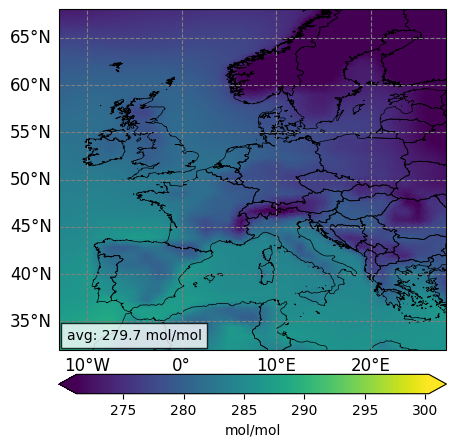

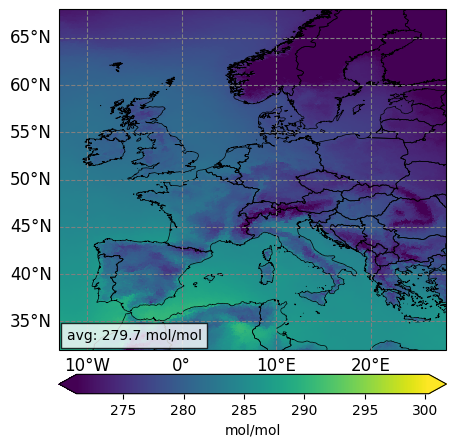

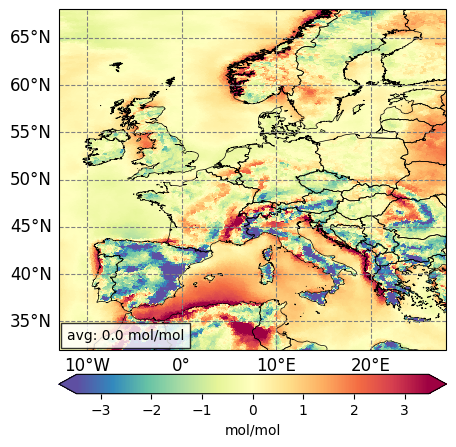

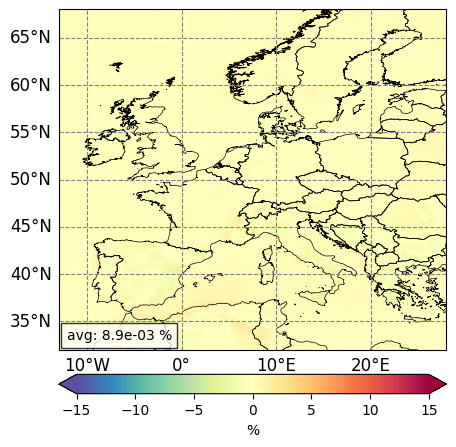

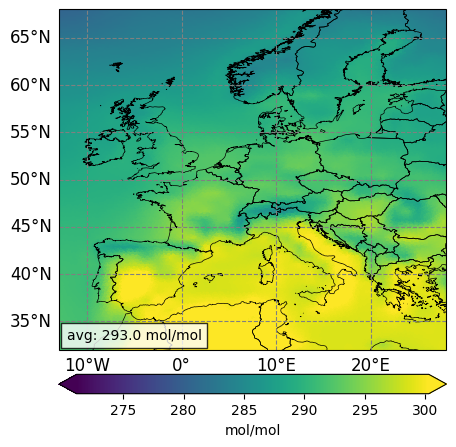

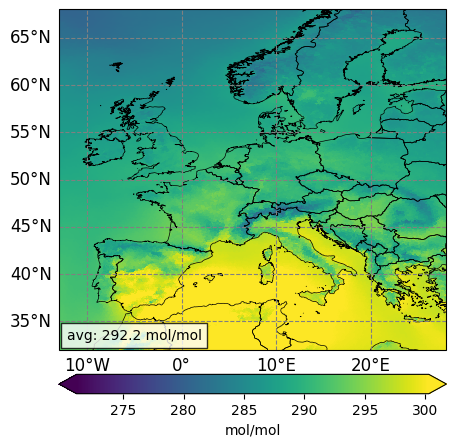

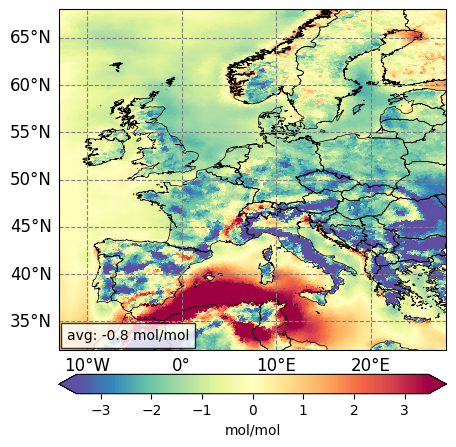

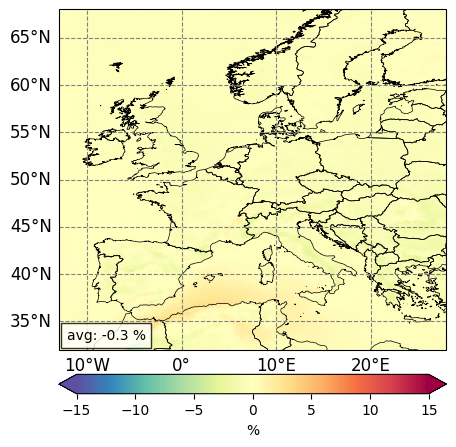

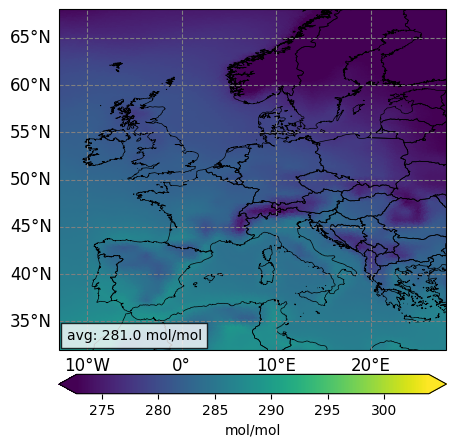

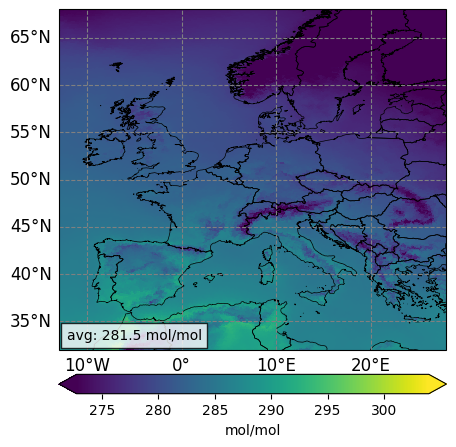

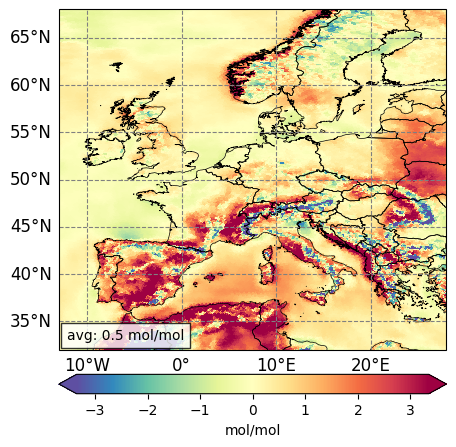

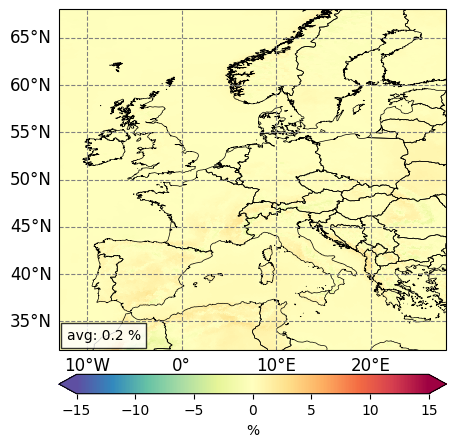

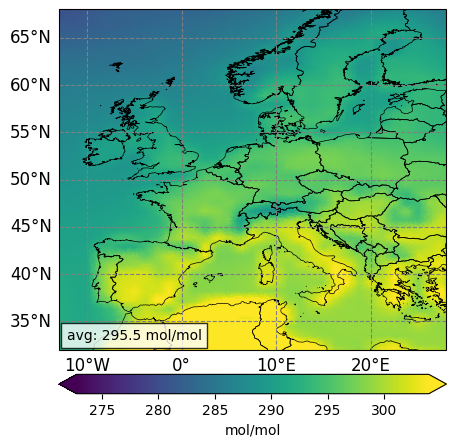

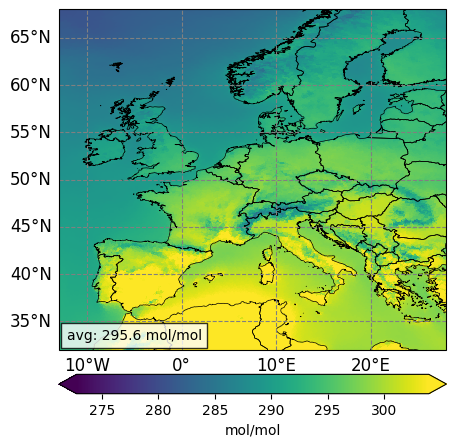

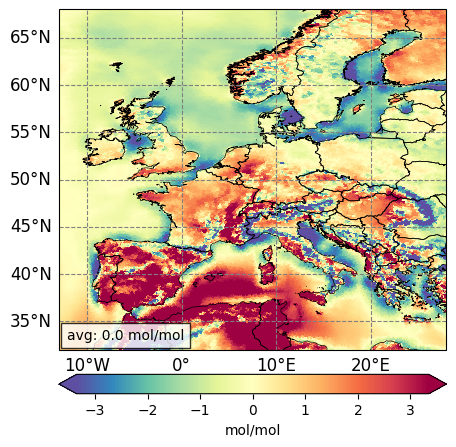

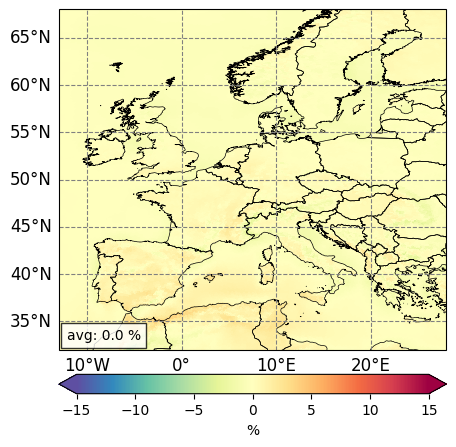

In [8]:
import numpy as np
import xarray as xr
from matplotlib.colors import Normalize

# Load dataset
ds_base = xr.open_dataset('/scratch/snx3000/amols/NO2_col_comp/column_comp_results/TROPOMI_on_ICON/TROPOMI_on_ICON_20190212_0.nc')
outpath = '/scratch/snx3000/amols/icon_maps/figs/temp'

# Define species and settings
# species_list = ['NO2', 'NO', 'HNO3', 'N2O5', 'PAN', 'NOx', 'NOy', 'NOz', 'NOx_NOy', 'NOx_NO2', 'O3', 'OH', 'CH3CHO', 'CO', 'temp']
species_list = ['temp']
months = ['02','07']
#level = 0  # Assuming all plots are at level 0
level = 1  # Assuming all plots are at level 0
hours = ['00', '12']

for hour in hours:
    # Pre-compute scale limits
    scale_limits = {}

    for species in species_list:
        scale_limits[species] = {}
        data_concat = []
        bias_data_concat = []
        change_data_concat = []  # Initialize list to collect change data
        for month in months:
            for tag in ['camchem', 'icon']:
                var_name = f'mean_{tag}_{species}_2019{month}T{hour}'
                var_data = globals()[var_name][level]
                data_concat.append(var_data)
            
            # Collecting bias data separately for different percentile calculation
            bias_var_name = f'mean_bias_{species}_2019{month}T{hour}'
            bias_var_data = globals()[bias_var_name][level]
            bias_data_concat.append(bias_var_data)
            
            # Collect change data
            change_var_name = f'mean_change_{species}_2019{month}T{hour}'
            change_var_data = globals()[change_var_name][level]
            change_data_concat.append(change_var_data)
        
        # Compute percentiles for camchem and icon
        combined_data = xr.concat(data_concat, dim='concat_dim')
        vmin = combined_data.quantile(0.05)  # 5th percentile
        vmax = combined_data.quantile(0.95)  # 95th percentile
        scale_limits[species]['camchem_icon'] = (vmin, vmax)

        # Compute percentiles for bias
        combined_bias_data = xr.concat(bias_data_concat, dim='concat_dim')
        vmax_bias = np.max([np.abs(combined_bias_data.quantile(0.95)), np.abs(combined_bias_data.quantile(0.05))])
        scale_limits[species]['bias'] = (-vmax_bias, vmax_bias)
        
        # Compute percentiles for change
        combined_change_data = xr.concat(change_data_concat, dim='concat_dim')
        change_vmin = combined_change_data.quantile(0.15)
        change_vmax = combined_change_data.quantile(0.85)
        
        # # Adjust vmin and vmax for change plot
        # if change_vmin <= -100 or change_vmax >= 100:
        #     vmin, vmax = -180, 180
        # else:
        #     vmin, vmax = -100, 100  # If the quartiles exceed -180 to 180 range, set it to -100 to 100

        vmin, vmax = -15, 15

        scale_limits[species]['change'] = (vmin, vmax)

    # Plotting loop
    for row, month in enumerate(months):
        for col, species in enumerate(species_list):
            date = f'2019{month}T{hour}'
            for idx, tag in enumerate(['camchem', 'icon', 'bias', 'change']):
                if tag in ['camchem', 'icon']:
                    vmin, vmax = scale_limits[species]['camchem_icon']
                    unit, scale, colormap = 'mol/mol', Normalize, 'viridis'
                elif tag == 'bias':
                    vmin, vmax = scale_limits[species]['bias']
                    unit, scale, colormap = 'mol/mol', Normalize, 'Spectral_r'
                else:
                    vmin, vmax = scale_limits[species]['change']
                    unit, scale, colormap = '%', Normalize, 'Spectral_r'
                    
                var_name = f'mean_{tag}_{species}_2019{month}T{hour}'
                var = globals()[var_name][level]

                # Plot data
                plot_ICON_map(ds_base, var, vmin, vmax, '', unit, scale, colormap, text=True, save=True, save_as=f'{tag}_avg_{species}_L{level}', output_path=outpath, date=f'2019{month}T{hour}')


In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Define the path where images are stored and the output path
image_path = '/scratch/snx3000/amols/icon_maps/figs'
output_path = '/scratch/snx3000/amols/icon_maps/combined_figs'

# List species, months, and plot types
species_list = ['NO2', 'NO', 'HNO3', 'N2O5', 'PAN', 'NOx', 'NOy', 'NOz', 'NOx_NOy', 'NOx_NO2', 'O3', 'OH', 'CH3CHO']
months = ['02', '07']
level = 4
tags = ['icon', 'camchem', 'bias', 'change']
hours = ['00','12']

for hour in hours:
    # Create a panel for each species
    for species in species_list:
        fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows and 4 columns
        for row, month in enumerate(months):
            for col, tag in enumerate(tags):
                # Construct filename
                if tag == 'change':
                    tag_name = 'Absolute difference'
                elif tag == 'bias':
                    tag_name = 'Relative difference'
                elif tag == 'icon':
                    tag_name = 'ICON'
                elif tag == 'camchem':
                    tag_name = 'CAM-Chem'

                filename = f'{tag}_avg_{species}_L{level}_2019{month}T{hour}.png'
                filepath = f'{image_path}/{filename}'

                # Load image
                img = mpimg.imread(filepath)

                # Plot image
                ax = axs[row, col]  # Adjust index to access correct subplot
                ax.imshow(img)
                ax.axis('off')  # Turn off axis
                ax.set_title(f'{tag_name} {month}/2019')

        plt.tight_layout()
        
        # Save the full figure for the species
        save_filename = f'2019T{hour}_panel_L{level}_{species}.png'
        plt.savefig(f'{output_path}/{save_filename}')
        plt.close(fig)  # Close the figure to free memory
    
print("Panels created and saved successfully.")

Panels created and saved successfully.


In [10]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Define the path where images are stored and the output path
image_path = '/scratch/snx3000/amols/icon_maps/figs'
output_path = '/scratch/snx3000/amols/icon_maps/overview_figs'

# Ensure output directory exists
os.makedirs(output_path, exist_ok=True)

# List species, months, and plot types
species_list = ['NO2', 'NO', 'NOx', 'NOz', 'NOy', 'NOx_NOy', 'HNO3', 'N2O5', 'PAN', 'O3', 'OH', 'CH3CHO']
months = ['02', '07']
tags = ['icon', 'change']
hours = ['00', '12']
level = 0  # You can change this level variable as needed

# Function to determine tag name
def get_tag_name(tag):
    if tag == 'change':
        return 'Relative difference (%)'
    elif tag == 'icon':
        return 'ICON-ART (mol/mol)'
    return tag

for month in months:
    for hour in hours:
        fig, axs = plt.subplots(6, 4, figsize=(20, 30))  # 6 rows and 4 columns
        for idx, species in enumerate(species_list):
            for j, tag in enumerate(tags):
                # Calculate row and column index
                row = (idx * 2 + j) // 4
                col = (idx * 2 + j) % 4

                # Construct filename
                filename = f'{tag}_avg_{species}_L{level}_2019{month}T{hour}.png'
                filepath = f'{image_path}/{filename}'

                # Load image
                img = mpimg.imread(filepath)

                # Plot image
                ax = axs[row, col]
                ax.imshow(img)
                ax.axis('off')  # Turn off axis

                # Add species name inside a white background box
                bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white", alpha=0.8)
                ax.text(0.5, 0.95, species, ha='center', va='top', transform=ax.transAxes, bbox=bbox_props)

                if col == 0 and j == 0:
                    ax.set_ylabel(get_tag_name(tag), fontsize=12, weight='bold')

        # Add title above each pair of columns
        for col, title in zip(range(0, 4, 1), ['ICON-ART (mol/mol)', 'Relative difference (%)']*2):
            axs[0, col].text(0.5, 1.05, title, ha='center', va='bottom', fontsize=14, transform=axs[0, col].transAxes)

        plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=-0.28, wspace=-0.01)  # Reduce margins
        
        # Save the full figure
        save_filename = f'2019{month}T{hour}_panel_L{level}_all_species.png'
        plt.savefig(f'{output_path}/{save_filename}')
        plt.close(fig)  # Close the figure to free memory
    
print("Panels created and saved successfully.")


Panels created and saved successfully.


##### Combined NOx and NOz plots

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Define the path where images are stored and the output path
image_path = '/scratch/snx3000/amols/icon_maps/figs'
output_path = '/scratch/snx3000/amols/icon_maps/overview_figs'

# Ensure output directory exists
os.makedirs(output_path, exist_ok=True)

# List months and plot types
months = ['02', '07']
tags = ['icon', 'change']
hours = ['12', '00']
season_labels = {'02': 'winter', '07': 'summer'}
species = 'NOx'
level = 5  # You can change this level variable as needed

# Function to determine tag name
def get_tag_name(tag):
    if tag == 'change':
        return 'Relative difference (%)'
    elif tag == 'icon':
        return 'ICON-ART (mol/mol)'
    return tag

# Create the 2x4 plot for NOx
fig, axs = plt.subplots(2, 4, figsize=(20, 10))  # 2 rows and 4 columns

for row_idx, hour in enumerate(hours):
    for col_idx, month in enumerate(months):
        for tag_idx, tag in enumerate(tags):
            # Calculate the overall column index
            overall_col_idx = col_idx * 2 + tag_idx

            # Construct filename
            filename = f'{tag}_avg_{species}_L{level}_2019{month}T{hour}.png'
            filepath = f'{image_path}/{filename}'

            # Load image
            if os.path.exists(filepath):
                img = mpimg.imread(filepath)
            else:
                img = None
                print(f"File not found: {filepath}")

            # Plot image
            ax = axs[row_idx, overall_col_idx]
            if img is not None:
                ax.imshow(img)
            ax.axis('off')  # Turn off axis

            # Add season and hour label inside a white background box
            label = f'{season_labels[month]} {hour}:00'
            bbox_props = dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="white", alpha=0.8)
            ax.text(0.5, 0.95, label, ha='center', va='top', transform=ax.transAxes, bbox=bbox_props, fontsize=14)

            # Set the tag name as ylabel only for the first column of each pair
            if tag_idx == 0:
                ax.set_ylabel(get_tag_name(tag), fontsize=12, weight='bold')

        # Add title above each pair of columns
        axs[0, col_idx * 2].text(0.5, 1.05, get_tag_name(tags[0]), ha='center', va='bottom', fontsize=14, transform=axs[0, col_idx * 2].transAxes)
        axs[0, col_idx * 2 + 1].text(0.5, 1.05, get_tag_name(tags[1]), ha='center', va='bottom', fontsize=14, transform=axs[0, col_idx * 2 + 1].transAxes)

plt.subplots_adjust(top=0.90, bottom=0.05, left=0.05, right=0.95, hspace=-0.3, wspace=-0.01)  # Reduce margins

# Save the full figure
save_filename = f'{species}_2019_panel_L{level}.png'
plt.savefig(f'{output_path}/{save_filename}')
plt.close(fig)  # Close the figure to free memory

print(f"{species} panels created and saved successfully.")


HNO3 panels created and saved successfully.


In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Define the path where images are stored and the output path
image_path = '/scratch/snx3000/amols/icon_maps/figs'
output_path = '/scratch/snx3000/amols/icon_maps/overview_figs'

# Ensure output directory exists
os.makedirs(output_path, exist_ok=True)

# Define the season (month)
month = '07'  # or '07' for summer
season_label = {'02': 'winter', '07': 'summer'}[month]

# List plot types and hours
tags = ['icon', 'change']
hours = ['12', '00']
species = 'NOx'
level = 3  # You can change this level variable as needed

# Function to determine tag name
def get_tag_name(tag):
    if tag == 'change':
        return 'Relative difference (%)'
    elif tag == 'icon':
        return 'ICON-ART (mol/mol)'
    return tag

# Create the 1x4 plot for the specified season
fig, axs = plt.subplots(1, 4, figsize=(20, 5))  # 1 row and 4 columns

for col_idx, hour in enumerate(hours):
    for tag_idx, tag in enumerate(tags):
        # Calculate the overall column index
        overall_col_idx = col_idx * 2 + tag_idx

        # Construct filename
        filename = f'{tag}_avg_{species}_L{level}_2019{month}T{hour}.png'
        filepath = f'{image_path}/{filename}'

        # Load image
        if os.path.exists(filepath):
            img = mpimg.imread(filepath)
        else:
            img = None
            print(f"File not found: {filepath}")

        # Plot image
        ax = axs[overall_col_idx]
        if img is not None:
            ax.imshow(img)
        ax.axis('off')  # Turn off axis

        # Add hour and species label inside a white background box
        label = f'{species} {hour}:00'
        bbox_props = dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="white", alpha=0.8)
        ax.text(0.5, 0.95, label, ha='center', va='top', transform=ax.transAxes, bbox=bbox_props, fontsize=14)

        # Set the tag name as ylabel only for the first row
        if col_idx == 0 and tag_idx == 0:
            ax.set_ylabel(get_tag_name(tag), fontsize=12, weight='bold')

# Add titles above each column
for i, ax in enumerate(axs):
    tag_name = get_tag_name(tags[i % 2])  # Use modulo to alternate between 'icon' and 'change'
    ax.text(0.5, 1.05, tag_name, ha='center', va='bottom', fontsize=14, transform=ax.transAxes)

plt.subplots_adjust(top=0.90, bottom=0.05, left=0.05, right=0.95, wspace=-0.01)  # Reduce margins

# Save the full figure
save_filename = f'{species}_2019_{season_label}_L{level}.png'
plt.savefig(f'{output_path}/{save_filename}')
plt.close(fig)  # Close the figure to free memory

print(f"{species} panel for {season_label} created and saved successfully.")


File not found: /scratch/snx3000/amols/icon_maps/figs/icon_avg_NOx_L3_201907T12.png
File not found: /scratch/snx3000/amols/icon_maps/figs/change_avg_NOx_L3_201907T12.png
File not found: /scratch/snx3000/amols/icon_maps/figs/icon_avg_NOx_L3_201907T00.png
File not found: /scratch/snx3000/amols/icon_maps/figs/change_avg_NOx_L3_201907T00.png
NOx panel for summer created and saved successfully.


In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Define the path where images are stored and the output path
image_path = '/scratch/snx3000/amols/icon_maps/figs'
output_path = '/scratch/snx3000/amols/icon_maps/overview_figs'

# Ensure output directory exists
os.makedirs(output_path, exist_ok=True)

# Define the season (month)
month = '07'  # or '07' for summer
season_label = {'02': 'winter', '07': 'summer'}[month]

# List plot types, hours, and species
tags = ['icon', 'change']
hours = ['12', '00']
species_list = ['NOz', 'N2O5', 'PAN', 'OH']
level = 0  # You can change this level variable as needed

# Function to determine tag name
def get_tag_name(tag):
    if tag == 'change':
        return 'Relative difference (%)'
    elif tag == 'icon':
        return 'ICON-ART (mol/mol)'
    return tag

# Create the 3x4 plot for the specified species
fig, axs = plt.subplots(len(species_list), 4, figsize=(20, 15))  # 3 rows and 4 columns

for row_idx, species in enumerate(species_list):
    for col_idx, hour in enumerate(hours):
        for tag_idx, tag in enumerate(tags):
            # Calculate the overall column index
            overall_col_idx = col_idx * 2 + tag_idx

            # Construct filename
            filename = f'{tag}_avg_{species}_L{level}_2019{month}T{hour}.png'
            filepath = f'{image_path}/{filename}'

            # Load image
            if os.path.exists(filepath):
                img = mpimg.imread(filepath)
            else:
                img = None
                print(f"File not found: {filepath}")

            # Plot image
            ax = axs[row_idx, overall_col_idx]
            if img is not None:
                ax.imshow(img)
            ax.axis('off')  # Turn off axis

            # Add hour and species label inside a white background box
            label = f'{species} {hour}:00'
            bbox_props = dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="white", alpha=0.8)
            ax.text(0.5, 0.95, label, ha='center', va='top', transform=ax.transAxes, bbox=bbox_props, fontsize=14)

            # Set the tag name as ylabel only for the first column of each row
            if col_idx == 0 and tag_idx == 0:
                ax.set_ylabel(get_tag_name(tag), fontsize=12, weight='bold')

# Add titles above each column
for i, tag in enumerate(tags):
    for j in range(2):
        overall_col_idx = j * 2 + i
        axs[0, overall_col_idx].text(0.5, 1.05, get_tag_name(tag), ha='center', va='bottom', fontsize=14, transform=axs[0, overall_col_idx].transAxes)

plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=-0.1, wspace=-0.45)  # Reduce margins

# Save the full figure
save_filename = f'combined_{season_label}_2019_L{level}.png'
plt.savefig(f'{output_path}/{save_filename}')
plt.close(fig)  # Close the figure to free memory

print(f"Panels for {species_list} in {season_label} created and saved successfully.")


Panels for ['NOz', 'N2O5', 'PAN', 'OH'] in summer created and saved successfully.


In [23]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Define the path where images are stored and the output path
image_path = '/scratch/snx3000/amols/icon_maps/figs'
output_path = '/scratch/snx3000/amols/icon_maps/overview_figs'

# Ensure output directory exists
os.makedirs(output_path, exist_ok=True)

# Define the season (month)
month = '07'  # or '07' for summer
season_label = {'02': 'winter', '07': 'summer'}[month]

# List plot types, hours, and species
tags = ['icon', 'change']
hours = ['12', '00']
species_list = ['NOz', 'N2O5', 'HNO3', 'PAN', 'OH']
level = 0  # You can change this level variable as needed

# Function to determine tag name
def get_tag_name(tag):
    if tag == 'change':
        return 'Relative difference (%)'
    elif tag == 'icon':
        return 'ICON-ART (mol/mol)'
    return tag

# Create the 3x4 plot for the specified species
fig, axs = plt.subplots(len(species_list), 4, figsize=(20, 15))  # 3 rows and 4 columns

for row_idx, species in enumerate(species_list):
    for col_idx, hour in enumerate(hours):
        for tag_idx, tag in enumerate(tags):
            # Calculate the overall column index
            overall_col_idx = col_idx * 2 + tag_idx

            # Construct filename
            filename = f'{tag}_avg_{species}_L{level}_2019{month}T{hour}.png'
            filepath = f'{image_path}/{filename}'

            # Load image
            if os.path.exists(filepath):
                img = mpimg.imread(filepath)
            else:
                img = None
                print(f"File not found: {filepath}")

            # Plot image
            ax = axs[row_idx, overall_col_idx]
            if img is not None:
                ax.imshow(img)
            ax.axis('off')  # Turn off axis

            # Add hour and species label inside a white background box
            label = f'{species} {hour}:00'
            bbox_props = dict(boxstyle="round,pad=0.5", edgecolor="black", facecolor="white", alpha=0.8)
            ax.text(0.5, 0.95, label, ha='center', va='top', transform=ax.transAxes, bbox=bbox_props, fontsize=12)

            # Set the tag name as ylabel only for the first column of each row
            if col_idx == 0 and tag_idx == 0:
                ax.set_ylabel(get_tag_name(tag), fontsize=11, weight='bold')

# Add titles above each column
for i, tag in enumerate(tags):
    for j in range(2):
        overall_col_idx = j * 2 + i
        axs[0, overall_col_idx].text(0.5, 1.05, get_tag_name(tag), ha='center', va='bottom', fontsize=14, transform=axs[0, overall_col_idx].transAxes)

plt.subplots_adjust(top=0.95, bottom=0.05, left=0.05, right=0.95, hspace=-0.06, wspace=-0.65)  # Reduce margins

# Save the full figure
save_filename = f'combined_{season_label}_2019_L{level}.png'
plt.savefig(f'{output_path}/{save_filename}')
plt.close(fig)  # Close the figure to free memory

print(f"Panels for {species_list} in {season_label} created and saved successfully.")


Panels for ['NOz', 'N2O5', 'HNO3', 'PAN', 'OH'] in summer created and saved successfully.


### Calculate statistics

In [20]:
import numpy as np
import pandas as pd

ds_base = xr.open_dataset('/scratch/snx3000/amols/NO2_col_comp/column_comp_results/TROPOMI_on_ICON/TROPOMI_on_ICON_20190212_0.nc')

# Define the function to calculate NMBE
def normalized_mean_bias_error(true, pred):
    nmbe = 2 * np.nanmean(pred - true) / (np.nanmean(pred) + np.nanmean(true)) * 100
    return nmbe

# List species, months, and plot types
species_list = ['NO2', 'NO', 'HNO3', 'N2O5', 'PAN', 'NOx', 'NOy', 'NOz', 'NOx_NOy', 'NOx_NO2', 'O3', 'OH', 'CH3CHO']
months = ['02', '07']
level = 5
tags = ['icon', 'camchem', 'bias', 'change']
hour = '00'

# Define domain boundaries
min_lon_med, max_lon_med, min_lat_med, max_lat_med = 4, 26, 33.5, 45
min_lon_eur, max_lon_eur, min_lat_eur, max_lat_eur = 0, 22, 46, 57

# Masks for the Mediterranean domain
mask_lon_med = (np.rad2deg(ds_base.clon) >= min_lon_med) & (np.rad2deg(ds_base.clon) <= max_lon_med)
mask_lat_med = (np.rad2deg(ds_base.clat) >= min_lat_med) & (np.rad2deg(ds_base.clat) <= max_lat_med)
mask_med = mask_lon_med & mask_lat_med

# Masks for the NW-Europe domain
mask_lon_eur = (np.rad2deg(ds_base.clon) >= min_lon_eur) & (np.rad2deg(ds_base.clon) <= max_lon_eur)
mask_lat_eur = (np.rad2deg(ds_base.clat) >= min_lat_eur) & (np.rad2deg(ds_base.clat) <= max_lat_eur)
mask_eur = mask_lon_eur & mask_lat_eur

# Initialize an empty list to collect data
avg_change_data = []

# Process each variable
for month in months:
    for species in species_list:
        # Construct the variable names to look up
        var_name_change = f'mean_change_{species}_2019{month}T{hour}'
        var_name_icon = f'mean_icon_{species}_2019{month}T{hour}'
        var_name_camchem = f'mean_camchem_{species}_2019{month}T{hour}'

        # Load data using globals()
        var_change = globals()[var_name_change][level]
        var_icon = globals()[var_name_icon][level]
        var_camchem = globals()[var_name_camchem][level]

        # Calculate the total average change value
        avg_change_value_total = var_change.mean().values.item()
        
        # Calculate the average change value for Mediterranean domain
        avg_change_value_med = var_change.where(mask_med).mean().values.item()
        
        # Calculate the average change value for NW-Europe domain
        avg_change_value_eur = var_change.where(mask_eur).mean().values.item()

        # Calculate NMBE for the whole domain
        nmbe_total = normalized_mean_bias_error(true=var_camchem.values, pred=var_icon.values)
        
        # Calculate NMBE for the Mediterranean domain
        nmbe_med = normalized_mean_bias_error(true=var_camchem.where(mask_med).values, pred=var_icon.where(mask_med).values)
        
        # Calculate NMBE for the NW-Europe domain
        nmbe_eur = normalized_mean_bias_error(true=var_camchem.where(mask_eur).values, pred=var_icon.where(mask_eur).values)
        
        # Determine the unit
        unit = '%'
        
        # Append data to list
        avg_change_data.append({
            'Species': species,
            'Month': month,
            'Total relative difference': f'{avg_change_value_total:.1f} {unit}',
            'Mediterranean relative difference': f'{avg_change_value_med:.1f} {unit}',
            'NW-Europe relative difference': f'{avg_change_value_eur:.1f} {unit}',
            # 'NMBE Total': f'{nmbe_total:.1f} {unit}',
            # 'NMBE Mediterranean': f'{nmbe_med:.1f} {unit}',
            # 'NMBE NW-Europe': f'{nmbe_eur:.1f} {unit}'
        })

# Create DataFrame from list of dictionaries
avg_change_df = pd.DataFrame(avg_change_data)

# Print or save the DataFrame
print(avg_change_df)
# avg_change_df.to_csv('/path/to/save/average_change_values_table.csv', index=False)


    Species Month Total relative difference Mediterranean relative difference  \
0       NO2    02                    22.4 %                            25.1 %   
1        NO    02                  -175.8 %                          -192.5 %   
2      HNO3    02                   -42.6 %                           -40.3 %   
3      N2O5    02                    32.3 %                            40.5 %   
4       PAN    02                    -2.7 %                           -10.0 %   
5       NOx    02                    22.3 %                            25.1 %   
6       NOy    02                    -0.7 %                            -3.1 %   
7       NOz    02                    -6.1 %                            -9.3 %   
8   NOx_NOy    02                    24.8 %                            30.5 %   
9   NOx_NO2    02                    -0.0 %                            -0.0 %   
10       O3    02                     7.0 %                             7.5 %   
11       OH    02           

#### Calculate averages of species

In [8]:
# List species, months, and plot types
species=['NO2', 'NO', 'HNO3', 'N2O5', 'PAN', 'NOx', 'NOy', 'NOz', 'NOx_NOy', 'NOx_NO2', 'O3', 'ALKNO3', 'HNO4', 'LHONITR', 'LISOPBDNO3', 'LISOPACNO3', 'MPAN', 'NO3', 'NOA', 'LONITR', 'PBZNIT', 'BPINANO3']


days = list(range(15, 26))  # Days 13-26
hour = '00'
month = '02'
unit = 'mol/mol'
level = 0

for specie in species:
    avgs_icon = []
    for day in days:
        icon_ds = xr.open_dataset(f'{ICON_filepath}/interp_icon_2019{month}{day}T{hour}.nc')

        no2_icon = icon_ds[specie][level]
        avgs_icon.append(no2_icon)

    # Concatenate and calculate means
    combined_avgs_icon = xr.concat(avgs_icon, dim='file')
    mean_icon = np.nanmedian(combined_avgs_icon.median(dim='file').values)

    print(f'mean {specie} {month}:{mean_icon:.2e} {unit}')

species = ['HNO3', 'N2O5', 'ALKNO3', 'HNO4', 'LHONITR', 'LISOPBDNO3', 'LISOPACNO3', 'MPAN', 'NO3', 'NOA', 'LONITR', 'PAN', 'PBZNIT', 'BPINANO3']

total_species_percentage = 0  # Variable to store the total percentage of all species compared to NOz

for specie in species:
    avgs_icon = []
    avgs_noz = []  # Separate list for NOz
    for day in days:
        icon_ds = xr.open_dataset(f'{ICON_filepath}/interp_icon_2019{month}{day}T{hour}.nc')

        # Extracting data for the specific species and NOz
        species_data = icon_ds[specie][level]
        noz_data = icon_ds['NOz'][level]

        # Appending the data for the species and NOz to their respective lists
        avgs_icon.append(species_data)
        avgs_noz.append(noz_data)

    # Concatenate the data for the species and NOz
    combined_avgs_icon = xr.concat(avgs_icon, dim='file')
    combined_avgs_noz = xr.concat(avgs_noz, dim='file')
    
    # Calculating the median for the combined data
    median_icon = np.nanmean(combined_avgs_icon.median(dim='file').values)
    median_noz = np.nanmean(combined_avgs_noz.median(dim='file').values)

    # Calculating the ratio of the species to NOz
    ratio = median_icon / median_noz

    # Expressing the ratio as a percentage of NOz
    percentage = ratio * 100
    
    # Accumulating the percentage for all species
    total_species_percentage += percentage

    print(f'Percentage of {specie} compared to NOz in {month}: {percentage:.2f}%')

print(f'Total percentage of all species compared to NOz in {month}: {total_species_percentage:.2f}%')



mean NO2 02:1.02e-09 mol/mol
mean NO 02:3.49e-14 mol/mol
mean HNO3 02:7.02e-11 mol/mol
mean N2O5 02:1.92e-10 mol/mol
mean PAN 02:2.54e-10 mol/mol
mean NOx 02:1.02e-09 mol/mol
mean NOy 02:1.92e-09 mol/mol
mean NOz 02:7.34e-10 mol/mol
mean NOx_NOy 02:5.57e-01 mol/mol
mean NOx_NO2 02:1.00e+00 mol/mol
mean O3 02:3.80e-08 mol/mol
mean ALKNO3 02:1.81e-11 mol/mol
mean HNO4 02:8.08e-13 mol/mol
mean LHONITR 02:9.01e-13 mol/mol
mean LISOPBDNO3 02:4.39e-13 mol/mol
mean LISOPACNO3 02:2.90e-13 mol/mol
mean MPAN 02:1.33e-15 mol/mol
mean NO3 02:2.45e-11 mol/mol
mean NOA 02:7.32e-12 mol/mol
mean LONITR 02:1.75e-12 mol/mol
mean PBZNIT 02:2.22e-12 mol/mol
mean BPINANO3 02:1.55e-12 mol/mol
Percentage of HNO3 compared to NOz in 02: 20.74%
Percentage of N2O5 compared to NOz in 02: 34.34%
Percentage of ALKNO3 compared to NOz in 02: 2.34%
Percentage of HNO4 compared to NOz in 02: 1.11%
Percentage of LHONITR compared to NOz in 02: 0.19%
Percentage of LISOPBDNO3 compared to NOz in 02: 0.13%
Percentage of LISOP

       Species  Percentage Hour
0         HNO3   42.588860   12
1         N2O5    0.132841   12
2       ALKNO3    3.732868   12
3         HNO4    0.540526   12
4      LHONITR    0.327212   12
5   LISOPBDNO3    0.286412   12
6   LISOPACNO3    0.190278   12
7         MPAN    0.001000   12
8          NO3    0.014034   12
9          NOA    2.577997   12
10      LONITR    0.507701   12
11         PAN   46.639561   12
12      PBZNIT    0.481499   12
13    BPINANO3    0.345391   12
14        HNO3   20.742067   00
15        N2O5   34.343816   00
16      ALKNO3    2.343659   00
17        HNO4    1.114469   00
18     LHONITR    0.187132   00
19  LISOPBDNO3    0.130311   00
20  LISOPACNO3    0.086302   00
21        MPAN    0.000594   00
22         NO3    5.187289   00
23         NOA    1.442087   00
24      LONITR    0.307670   00
25         PAN   30.067384   00
26      PBZNIT    0.315290   00
27    BPINANO3    0.314474   00


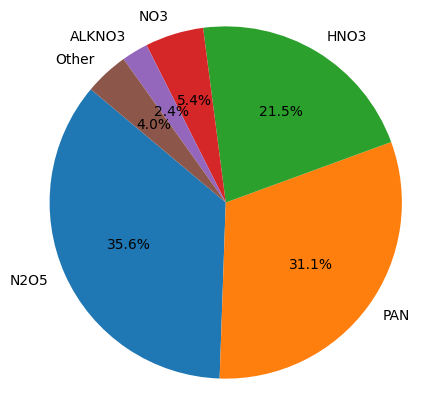

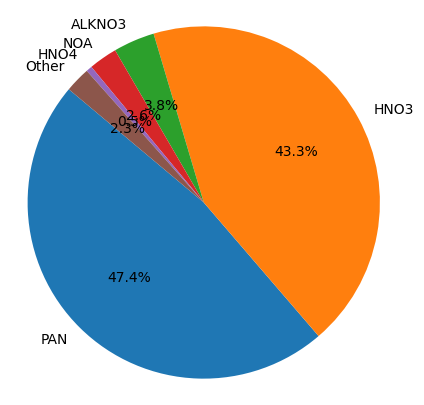

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Initialize an empty list to store the results
results = []

# Iterate over each species for both 12:00 and 00:00
for hour in ['12', '00']:
    for specie in species:
        avgs_icon = []
        avgs_noz = []  # Separate list for NOz
        for day in days:
            icon_ds = xr.open_dataset(f'{ICON_filepath}/interp_icon_2019{month}{day}T{hour}.nc')

            # Extracting data for the specific species and NOz
            species_data = icon_ds[specie][level]
            noz_data = icon_ds['NOz'][level]

            # Appending the data for the species and NOz to their respective lists
            avgs_icon.append(species_data)
            avgs_noz.append(noz_data)

        # Concatenate the data for the species and NOz
        combined_avgs_icon = xr.concat(avgs_icon, dim='file')
        combined_avgs_noz = xr.concat(avgs_noz, dim='file')
        
        # Calculating the median for the combined data
        median_icon = np.nanmean(combined_avgs_icon.median(dim='file').values)
        median_noz = np.nanmean(combined_avgs_noz.median(dim='file').values)

        # Calculating the ratio of the species to NOz
        ratio = median_icon / median_noz

        # Expressing the ratio as a percentage of NOz
        percentage = ratio * 100
        
        # Append the results to the list
        results.append({'Species': specie, 'Percentage': percentage, 'Hour': hour})

# Convert the list of results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results DataFrame
print(results_df)


# Filter the results for 00:00 and 12:00 hours
hour_00_results = results_df[results_df['Hour'] == '00']
hour_12_results = results_df[results_df['Hour'] == '12']

# Function to plot pie chart
def plot_pie_chart(results, title, hour):
    # Sort the results by percentage
    results = results.sort_values(by='Percentage', ascending=False)
    
    # Get the top 5 species
    top_5 = results.head(5)
    
    # Sum up percentages of the remaining species
    other_percentage = results['Percentage'].sum() - top_5['Percentage'].sum()
    
    # Create a DataFrame for 'Other' category
    other_df = pd.DataFrame({'Species': ['Other'], 'Percentage': [other_percentage]})
    
    # Concatenate 'Other' with the top 5
    combined_results = pd.concat([top_5, other_df])
    
    plt.figure(figsize=(5, 5))
    plt.pie(combined_results['Percentage'], labels=combined_results['Species'], autopct='%1.1f%%', startangle=140, textprops={'fontsize': 10})
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    plt.savefig(f'./piecharts/pie_{month}_{hour}', dpi=300)
    plt.show()

# Plot pie chart for 00:00
plot_pie_chart(hour_00_results, 'NOz species at 00:00 in February', '00')

# Plot pie chart for 12:00
plot_pie_chart(hour_12_results, 'NOz species at 12:00 in February', '12')


In [13]:
month

'02'